## 导入模型

In [1]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout

In [2]:
# 神经网络配置
max_features = 40001
maxlen = 100
batch_size = 256
embedding_dims = 50
epochs = 8
vocab_size = 40000


In [3]:
class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=input, outputs=output)
        return model

In [4]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt 
plt.switch_backend('agg')
%matplotlib inline

In [5]:
import sys
from collections import Counter
import numpy as np
import tensorflow.keras as kr
import os

## 定义一些数据处理函数

In [6]:
def read_vocab(vocab_file):
    """读取词汇表"""
    # words = open_file(vocab_dir).read().strip().split('\n')
    with open(vocab_file,mode='r',encoding='utf-8') as fp:
        # 如果是py2 则每个值都转化为unicode
        words = [_.strip() for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

def encode_cate(content, words):
    """将id表示的内容转换为文字"""
    return [(words[x] if x in words else 40000) for x in content]

def encode_sentences(contents, words):
    """将id表示的内容转换为文字"""
    return [encode_cate(x,words) for x in contents]

这是一些类型的转换

In [7]:
age_to_id = {1:0,2:1,3:2,4:3,5:4,6:5}
gender_to_id = {1:0,2:1}
education_to_id = {1:0,2:1,3:2,4:3,5:4,6:5}

In [8]:
vocab_file_age = './Data/VersonData_4/vocab_file_age'
vocab_file_gender = './Data/VersonData_4/vocab_file_gender'
vocab_file_education = './Data/VersonData_4/vocab_file_education'

## 表征搭建

In [9]:
file_proce_path = './Data/VersonData_2/traindf.csv'
traindf = pd.read_csv(file_proce_path,encoding='utf-8')
traindf.head()

,ID,Age,Gender,Education,Query List
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,柔和 双沟 女生 中财网 首页 财经 周公 解梦 大全 查询 2345 曹云金 再讽 郭德纲...
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,广州 厨宝 烤箱 世情 人情 雨送 黄昏 花易落 风干 泪痕 厦门 酒店用品 批发市场 不想...
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,钻石 之泪 耳机 盘锦 沈阳 旅顺 公交 辽宁 阜新 车牌 baidu k715 k716 ...
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,受欢迎 狗狗 排行榜 场景 范例 三维 绘图 软件 酸奶 壮观 衣服 网站 动漫 绘图 软件...
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,干槽症 自愈 太太 万岁 舒心 美国 干槽症 眼皮 怎么回事 麦当劳 旋风 勺子 吉林市 鹿...


### age测试

In [10]:
agedf= traindf[['Age','Query List']]
agedf = agedf[agedf['Age']!=0]
X_age = agedf['Query List'].values.tolist()
Y_age = agedf['Age'].values.tolist()

In [11]:
age_words, age_word_to_id = read_vocab(vocab_file_age)

In [12]:
#数据打乱 
data = list(zip(X_age,Y_age))
del X_age,Y_age
random.shuffle(data)
X_age,Y_age = zip(*data)

In [13]:
datax_train, datax_test,datay_train,datay_test = train_test_split(X_age,Y_age,random_state =33)

In [14]:
x_train = encode_sentences([content[0] for content in datax_train], age_word_to_id)
y_train = to_categorical(encode_cate(datay_train, age_to_id))
x_test = encode_sentences([content[0] for content in datax_test], age_word_to_id)
y_test = to_categorical(encode_cate(datay_test, age_to_id))

In [16]:
print('对序列做padding，保证是 samples*timestep 的维度')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

对序列做padding，保证是 samples*timestep 的维度
x_train shape: (73750, 100)
x_test shape: (24584, 100)
y_test shape: (24584, 6)


In [17]:
print('构建模型...')
age_model = TextCNN(maxlen, max_features, embedding_dims,class_num=6).get_model()
age_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

构建模型...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
# 设定callbacks回调函数
age_model_file = './Model/cnn_age_model.h5'
my_callbacks = [
    ModelCheckpoint(age_model_file, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

In [21]:
# fit拟合数据
history = age_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

Train on 73750 samples, validate on 24584 samples
Epoch 1/8
73216/73750 [============================>.] - ETA: 0s - loss: 1.4152 - acc: 0.3943
Epoch 00001: saving model to ./Model/cnn_age_model.h5
73750/73750 [==============================] - 7s 101us/sample - loss: 1.4151 - acc: 0.3945 - val_loss: 1.3875 - val_acc: 0.3992
Epoch 2/8
73216/73750 [============================>.] - ETA: 0s - loss: 1.3813 - acc: 0.4056
Epoch 00002: saving model to ./Model/cnn_age_model.h5
73750/73750 [==============================] - 6s 78us/sample - loss: 1.3812 - acc: 0.4055 - val_loss: 1.3896 - val_acc: 0.3967
Epoch 3/8
73216/73750 [============================>.] - ETA: 0s - loss: 1.3667 - acc: 0.4134
Epoch 00003: saving model to ./Model/cnn_age_model.h5
73750/73750 [==============================] - 6s 79us/sample - loss: 1.3665 - acc: 0.4135 - val_loss: 1.3961 - val_acc: 0.3976
Epoch 4/8
73216/73750 [============================>.] - ETA: 0s - loss: 1.3558 - acc: 0.4193
Epoch 00004: saving model t

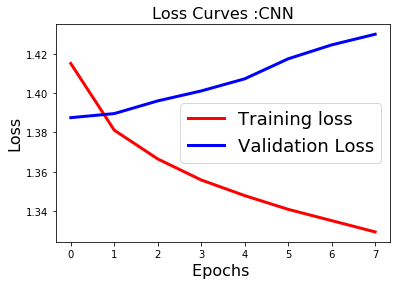

In [22]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
#fig1.savefig('../../tmp/loss_cnn.png')
plt.show()

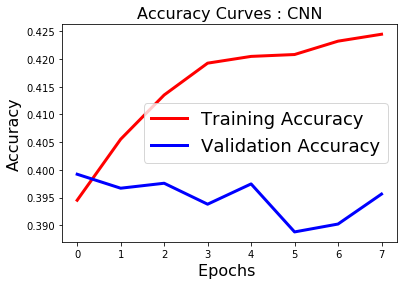

In [23]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
#fig2.savefig('../../tmp/accuracy_cnn.png')
plt.show()

### 改用分层抽样

In [16]:
from sklearn.model_selection import StratifiedKFold

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
npX = np.array(X_age)
npY = np.array(Y_age)

In [31]:
stratifiedk_fold = StratifiedKFold(n_splits=5, shuffle=True)
train_index=[] 
test_index = []
for ta_index,te_index  in stratifiedk_fold.split(npX, npY):
    train_index.append(ta_index)
    test_index.append(te_index)

In [32]:
x_train = npX[train_index[0]]
x_test = npX[test_index[0]]
y_train = npY[train_index[0]]
y_test = npY[test_index[0]]

In [36]:
xs_train = encode_sentences([content[0] for content in list(x_train)], age_word_to_id)
ys_train = to_categorical(encode_cate(list(y_train), age_to_id))
xs_test = encode_sentences([content[0] for content in list(x_test)], age_word_to_id)
ys_test = to_categorical(encode_cate(list(y_test), age_to_id))

In [38]:
print('对序列做padding，保证是 samples*timestep 的维度')
xs_train = sequence.pad_sequences(xs_train, maxlen=maxlen)
xs_test = sequence.pad_sequences(xs_test, maxlen=maxlen)
print('x_train shape:', xs_train.shape)
print('x_test shape:', xs_test.shape)
print('y_test shape:', ys_test.shape)

对序列做padding，保证是 samples*timestep 的维度
x_train shape: (78665, 100)
x_test shape: (19669, 100)
y_test shape: (19669, 6)


In [39]:
print('构建模型...')
age_model_sta = TextCNN(maxlen, max_features, embedding_dims,class_num=6).get_model()
age_model_sta.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

构建模型...


In [40]:
age_model_file = './Model/cnn_age2_model.h5'

In [43]:
# fit拟合数据
history = age_model_sta.fit(xs_train, ys_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(xs_test, ys_test))

Train on 78665 samples, validate on 19669 samples
Epoch 1/8
78592/78665 [============================>.] - ETA: 0s - loss: 1.4095 - acc: 0.3951
Epoch 00001: saving model to ./Model/cnn_age_model.h5
78665/78665 [==============================] - 7s 85us/sample - loss: 1.4094 - acc: 0.3951 - val_loss: 1.3949 - val_acc: 0.4007
Epoch 2/8
78592/78665 [============================>.] - ETA: 0s - loss: 1.3786 - acc: 0.4046
Epoch 00002: saving model to ./Model/cnn_age_model.h5
78665/78665 [==============================] - 6s 79us/sample - loss: 1.3786 - acc: 0.4046 - val_loss: 1.3948 - val_acc: 0.3884
Epoch 3/8
78592/78665 [============================>.] - ETA: 0s - loss: 1.3648 - acc: 0.4134
Epoch 00003: saving model to ./Model/cnn_age_model.h5
78665/78665 [==============================] - 6s 78us/sample - loss: 1.3649 - acc: 0.4135 - val_loss: 1.3979 - val_acc: 0.3944
Epoch 4/8
78592/78665 [============================>.] - ETA: 0s - loss: 1.3543 - acc: 0.4181
Epoch 00004: saving model to

In [24]:
def plt_show_loss(history):
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves :CNN',fontsize=16)
    plt.show()

    
def plt_show_acc(history):
    plt.plot(history.history['acc'],'r',linewidth=3.0)
    plt.plot(history.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves : CNN',fontsize=16)
    plt.show()  
    

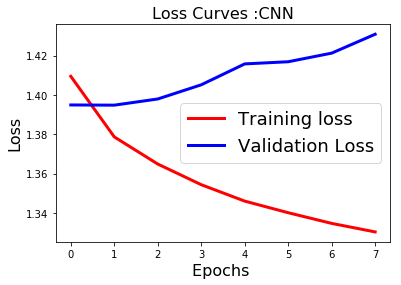

In [44]:
plt_show_loss(history)

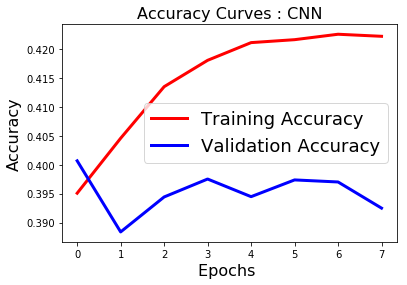

In [45]:
plt_show_acc(history)

## 测试性别

In [46]:
genderdf = traindf[['Age','Query List','Gender']]
genderdf = genderdf[genderdf['Gender']!= 0]
X_gender = genderdf['Query List'].values.tolist()
Y_gender = genderdf['Gender'].values.tolist() 
Y_ageflg = genderdf['Age'].values.tolist() 

In [47]:
gender_words, gender_word_to_id = read_vocab(vocab_file_gender)

In [48]:
npX_gender = np.array(X_gender)
npY_gender = np.array(Y_gender)
npY_ageflg = np.array(Y_ageflg)

In [49]:
train_index_gender=[] 
test_index_gender = []
for ta_index,te_index  in stratifiedk_fold.split(npX_gender, npY_ageflg):
    train_index_gender.append(ta_index)
    test_index_gender.append(te_index)

In [50]:
x_train = npX_gender[train_index_gender[0]]
x_test = npX_gender[test_index_gender[0]]
y_train = npY_gender[train_index_gender[0]]
y_test = npY_gender[test_index_gender[0]]

In [51]:
del age_model_sta,age_model

In [52]:
del npX,npY,X_age,Y_age

In [53]:
xs_train = encode_sentences([content[0] for content in list(x_train)], gender_word_to_id)
ys_train = to_categorical(encode_cate(list(y_train), gender_to_id))
xs_test = encode_sentences([content[0] for content in list(x_test)], gender_word_to_id)
ys_test = to_categorical(encode_cate(list(y_test), gender_to_id))

In [54]:
print('对序列做padding，保证是 samples*timestep 的维度')
xs_train = sequence.pad_sequences(xs_train, maxlen=maxlen)
xs_test = sequence.pad_sequences(xs_test, maxlen=maxlen)
print('x_train shape:', xs_train.shape)
print('x_test shape:', xs_test.shape)
print('y_test shape:', ys_test.shape)

对序列做padding，保证是 samples*timestep 的维度
x_train shape: (78273, 100)
x_test shape: (19572, 100)
y_test shape: (19572, 2)


In [57]:
print('构建模型...')
gender_model = TextCNN(maxlen, max_features, embedding_dims,class_num=2).get_model()
gender_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
gender_model_file = './Model/cnn_gender_model.h5'

构建模型...


In [56]:
del gender_model

In [58]:
# fit拟合数据
history_gender = gender_model.fit(xs_train, ys_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(xs_test, ys_test))

Train on 78273 samples, validate on 19572 samples
Epoch 1/8
77824/78273 [============================>.] - ETA: 0s - loss: 0.6700 - acc: 0.5920
Epoch 00001: saving model to ./Model/cnn_age_model.h5
78273/78273 [==============================] - 8s 101us/sample - loss: 0.6699 - acc: 0.5923 - val_loss: 0.6690 - val_acc: 0.5917
Epoch 2/8
77824/78273 [============================>.] - ETA: 0s - loss: 0.6550 - acc: 0.6126
Epoch 00002: saving model to ./Model/cnn_age_model.h5
78273/78273 [==============================] - 6s 79us/sample - loss: 0.6551 - acc: 0.6125 - val_loss: 0.6694 - val_acc: 0.5937
Epoch 3/8
77824/78273 [============================>.] - ETA: 0s - loss: 0.6504 - acc: 0.6186
Epoch 00003: saving model to ./Model/cnn_age_model.h5
78273/78273 [==============================] - 6s 82us/sample - loss: 0.6503 - acc: 0.6187 - val_loss: 0.6750 - val_acc: 0.5941
Epoch 4/8
77824/78273 [============================>.] - ETA: 0s - loss: 0.6469 - acc: 0.6218
Epoch 00004: saving model t

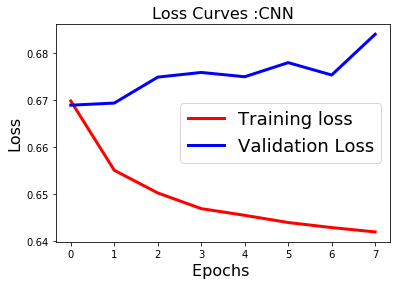

In [60]:
plt_show_loss(history_gender)

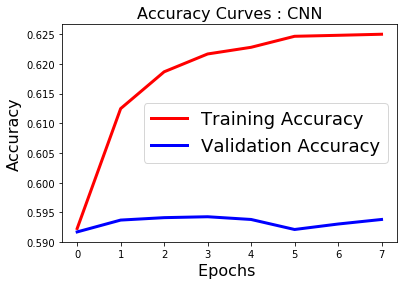

In [61]:
plt_show_acc(history_gender)

## 测试学历

In [11]:
educationdf = traindf[['Education','Query List']]
educationdf = educationdf[educationdf['Education']!=0]
X_education = educationdf['Query List'].values.tolist()
Y_education = educationdf['Education'].values.tolist() 

In [12]:
education_words, education_word_to_id = read_vocab(vocab_file_education)

In [13]:
npX_education = np.array(X_education)
npY_education = np.array(Y_education)

In [18]:

stratifiedk_fold = StratifiedKFold(n_splits=5, shuffle=True)
train_index_education=[] 
test_index_education = []
for ta_index,te_index  in stratifiedk_fold.split(npX_education, npY_education):
    train_index_education.append(ta_index)
    test_index_education.append(te_index)

In [19]:
x_train = npX_education[train_index_education[0]]
x_test = npX_education[test_index_education[0]]
y_train = npY_education[train_index_education[0]]
y_test = npY_education[test_index_education[0]]

In [20]:
xs_train = encode_sentences([content[0] for content in list(x_train)], education_word_to_id)
ys_train = to_categorical(encode_cate(list(y_train), education_to_id))
xs_test = encode_sentences([content[0] for content in list(x_test)], education_word_to_id)
ys_test = to_categorical(encode_cate(list(y_test), education_to_id))

In [21]:
print('对序列做padding，保证是 samples*timestep 的维度')
xs_train = sequence.pad_sequences(xs_train, maxlen=maxlen)
xs_test = sequence.pad_sequences(xs_test, maxlen=maxlen)
print('x_train shape:', xs_train.shape)
print('x_test shape:', xs_test.shape)
print('y_test shape:', ys_test.shape)

对序列做padding，保证是 samples*timestep 的维度
x_train shape: (72574, 100)
x_test shape: (18146, 100)
y_test shape: (18146, 6)


In [22]:
print('构建模型...')
education_model = TextCNN(maxlen, max_features, embedding_dims,class_num=6).get_model()
education_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
education_model_file = './Model/cnn_education_model.h5'

构建模型...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [23]:
# fit拟合数据
history_education = education_model.fit(xs_train, ys_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(xs_test, ys_test))

Train on 72574 samples, validate on 18146 samples
Epoch 1/8
72448/72574 [============================>.] - ETA: 0s - loss: 1.2962 - acc: 0.4055
Epoch 00001: saving model to ./Model/cnn_age_model.h5
72574/72574 [==============================] - 11s 158us/sample - loss: 1.2962 - acc: 0.4056 - val_loss: 1.2699 - val_acc: 0.4107
Epoch 2/8
72448/72574 [============================>.] - ETA: 0s - loss: 1.2571 - acc: 0.4264
Epoch 00002: saving model to ./Model/cnn_age_model.h5
72574/72574 [==============================] - 6s 78us/sample - loss: 1.2571 - acc: 0.4265 - val_loss: 1.2678 - val_acc: 0.4107
Epoch 3/8
72448/72574 [============================>.] - ETA: 0s - loss: 1.2442 - acc: 0.4348
Epoch 00003: saving model to ./Model/cnn_age_model.h5
72574/72574 [==============================] - 6s 78us/sample - loss: 1.2444 - acc: 0.4348 - val_loss: 1.2743 - val_acc: 0.4136
Epoch 4/8
72448/72574 [============================>.] - ETA: 0s - loss: 1.2342 - acc: 0.4384
Epoch 00004: saving model 

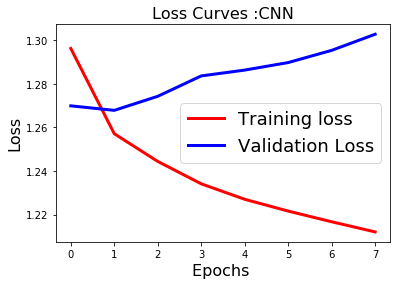

In [25]:
plt_show_loss(history_education)

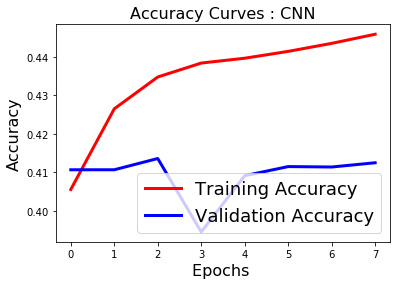

In [26]:
plt_show_acc(history_education)